# Neural Collaborative Filtering

Домашнее задание №3.

Самостоятельно реализовать архитектуру нейронной сети (на любом фреймфорке) для CF. На вход получает 2 бинарных вектора items и users.  На выход предсказываете рейтинг объекта.
1.  Использовать 3 полносвязанных слоев.
2.  Использовать 5 полносвязанных слоев.
Для каждой сети выбрать оптимальную функцию активации (по кросс-валидации) по метрике RMSE. Также можно попробовать оптимизировать другие параметры.
Сравнить качество сетей. Сделать развернутые выводы. Как можно улучшать архитектуру? Предложить улучшение архитектуру и реализовать его.

В качестве обучающего датасэта можно использовать любой, но рекомендуется использовать датасэт REKKO https://boosters.pro/championship/rekko_challenge/data (ranking.csv).

## Load Data & Make Splits

In [1]:
DATA_PATH = '/home/ilya/repos/recsys/data/rekko'

In [2]:
import pandas as pd
import os
import numpy as np

ratings = pd.read_csv(
    os.path.join(DATA_PATH, 'ratings.csv'),
    dtype={
        'element_uid': np.uint16,
        'user_uid': np.uint32,
        'ts': np.float64,
        'rating': np.uint8
    }
)

In [3]:
ratings.rating.unique()

array([10,  8,  9,  6,  5,  7,  2,  3,  4,  1,  0], dtype=uint8)

In [4]:
ratings

,user_uid,element_uid,rating,ts
0,571252,1364,10,4.430517e+07
1,63140,3037,10,4.430514e+07
2,443817,4363,8,4.430514e+07
3,359870,1364,10,4.430506e+07
4,359870,3578,9,4.430506e+07
...,...,...,...,...
438785,170707,1539,8,4.173086e+07
438786,32659,6127,8,4.173085e+07
438787,353752,3336,8,4.173079e+07
438788,492350,7984,7,4.173078e+07


<Axes: >

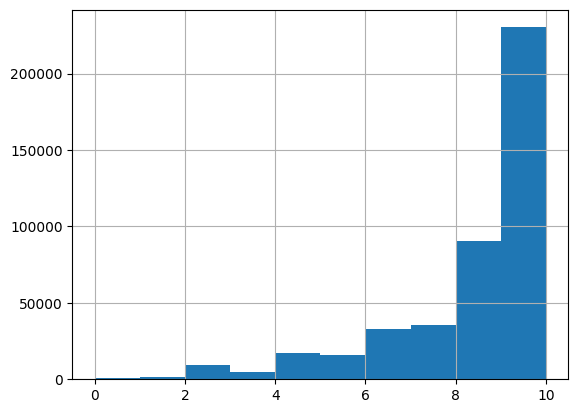

In [5]:
ratings.rating.hist()

В оригинальной статье https://arxiv.org/abs/1708.05031 модель обучалась в сеттинге implicit data на бинарные метки "релевантно"/"не релевантно". В случае Movielens авторы намеренно перевели explicit data по правилу "релевантно == есть оценка". Я поступлю так же. Плюс отфильтрую данные от пользователей, у которых меньше `min_num_of_ratings` оценок.

In [5]:
active_users = (ratings.user_uid.value_counts() >= 10).to_dict()
active_users = set(k for k, v in active_users.items() if v)
len(active_users)

9993

In [19]:
def assign_inner_ids(train, val):
    all_data = pd.concat([train, val], axis=0)
    users = all_data.user_uid.unique().tolist()
    items = all_data.element_uid.unique().tolist()

    for df in [train, val]:
        df['user_id'] = df.user_uid.map(lambda x: users.index(x))
        df['item_id'] = df.element_uid.map(lambda x: items.index(x))

    return train, val

In [20]:
def generate_implicit_folds(df, min_num_of_ratings=10):
    active_users = (df.user_uid.value_counts() >= min_num_of_ratings).to_dict()
    active_users = set(k for k, v in active_users.items() if v)
    
    train = []
    val = []

    for user_id in active_users:
        cur_df = df[df.user_uid == user_id]
        cur_df = cur_df.sort_values(by='ts', ascending=False)
        val.append(cur_df.iloc[0:1])
        train.append(cur_df.iloc[1:])
    train, val = [pd.concat(f, axis=0) for f in [train, val]]

    train, val = assign_inner_ids(train, val)
    
    return train, val

In [21]:
train, val = generate_implicit_folds(ratings)
train.shape, val.shape

((192847, 6), (9993, 6))

Из валидации нужно убрать те пары "пользователь-товар", в которых товар не встречался во время обучения. Если убираем такие пары из валидации, то соответствующего пользователя можно убрать из трейна, раз его не будем оценивать.

In [22]:
def filter(train, val):
    train_items = train.item_id.tolist()
    val_filtered = val[val.item_id.isin(train_items)]
    val_users = val_filtered.user_id.unique().tolist()
    train_filtered = train[train.user_id.isin(val_users)]
    return train_filtered, val_filtered

In [23]:
def check(train, val):
    check_users = set(train.user_id.unique()) == set(val.user_id.unique())
    check_items = set(val.item_id.unique()) - set(train.item_id.unique())
    print(check_users, check_items)

In [24]:
train_filtered, val_filtered = filter(train, val)
check(train_filtered, val_filtered)

True {6748}


In [25]:
val_filtered[val_filtered.user_id == 6748]

,user_uid,element_uid,rating,ts,user_id,item_id
15517,185937,8493,8,4.417204e+07,6748,1


In [26]:
val_filtered2 = val_filtered.drop(labels=15517)

train_filtered2, val_filtered2 = filter(train_filtered, val_filtered2)
check(train_filtered2, val_filtered2)

True set()


После фильтрации нужно переопределить внутренние индексы

In [27]:
train, val = assign_inner_ids(train_filtered2, val_filtered2)

/tmp/ipykernel_93538/327918135.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['user_id'] = df.user_uid.map(lambda x: users.index(x))
/tmp/ipykernel_93538/327918135.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['item_id'] = df.element_uid.map(lambda x: items.index(x))


Сохраняю данные на диск:

In [28]:
my_splits_path = os.path.join(DATA_PATH, 'my_splits')
if not os.path.exists(my_splits_path):
    os.makedirs(my_splits_path)

train_path = os.path.join(my_splits_path, f'train.csv')
train.to_csv(train_path, index_label='src_index')

val_path = os.path.join(my_splits_path, f'val.csv')
val.to_csv(val_path, index_label='src_index')

Во время обучения нужно семплить негативные примеры, т.е. пары "пользователь--товар", у которых нет оценки. Авторы статьи утверждают, что делали это на каждом шаге случайно из всего датасета. Реализую эту логику в виде параметра `n_negatives`: сколько негативных товаров для каждого пользователя возвращать вместе с позитивными.

In [34]:
all_data = pd.concat([train, val], axis=0)
all_items = set(all_data.item_id.unique())
positive_sets = all_data.groupby(by='user_id')['item_id'].agg(['unique'])['unique'].apply(set).to_dict()
positive_sets = {int(user_id): [int(x) for x in pos] for user_id, pos in positive_sets.items()}

Сохраним словарик "пользователь: все оценённые товары".

In [35]:
import json

path = os.path.join(DATA_PATH, 'my_splits', 'positive_sets.json')
json.dump(positive_sets, open(path, 'w'))

In [36]:
path = os.path.join(DATA_PATH, 'my_splits', 'all_items.json')
json.dump([int(x) for x in all_items], open(path, 'w'))

Статистики по числу негативных товаров:

In [37]:
negative_sets = {int(user_id): [int(x) for x in all_items.difference(pos)] for user_id, pos in positive_sets.items()}
lens = [len(x) for x in negative_sets.values()]
mean_len = sum(lens) / len(lens)
min_len = min(lens)
max_len = max(lens)

print(f'{mean_len=}, {min_len=}, {max_len=}')

mean_len=6831.7404165409, min_len=5992, max_len=6842


В виде торч датасета:

In [39]:
from hw3.neuralcolfil.datasets.implicit import RekkoImplicit

dataset = RekkoImplicit(
    n_negatives=10,
    split='val',
)
dataset[27]

[27, 289, 614, 4491, 2552, 682, 6504, 6673, 3162, 3014, 5387, 4568]

## MLP, GMF, NCF

### Архитектура

Согласно статье https://arxiv.org/abs/1708.05031, нужно сначала обучить отдельно MLP:

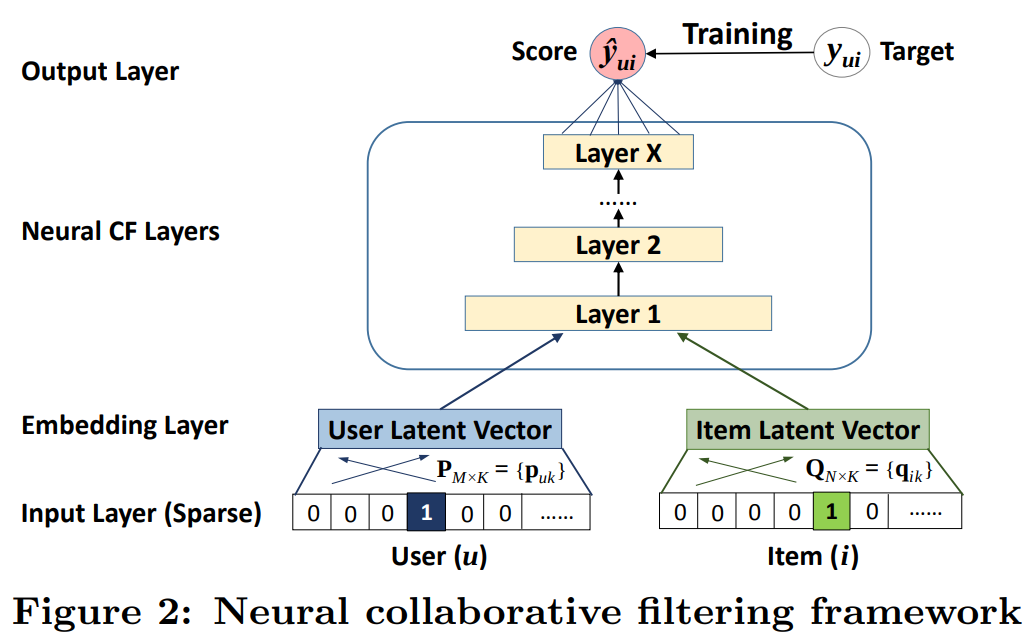

Затем GMF:
$$
\hat y_{ui}=\text{Sigmoid}(h^T(p_u\circ q_i))
$$

А потом взять обученные эмбеддинги GMF и обученные скрытые слои MLP и обучить полносвязный слой над их конкатенацией:

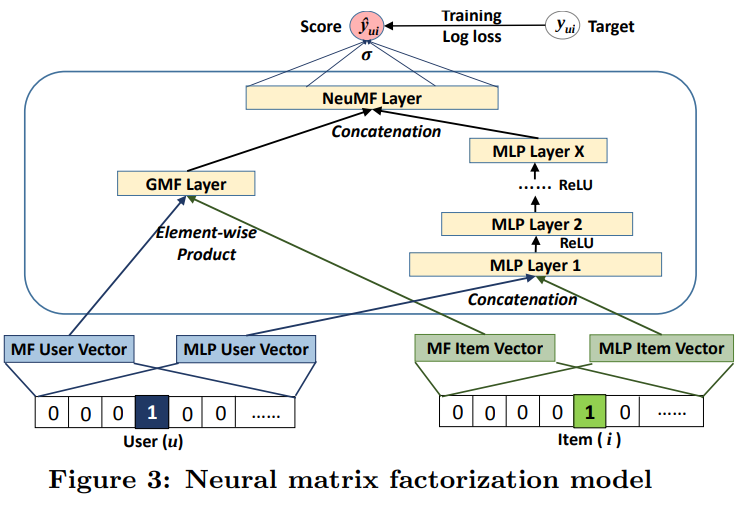

### Результат для трёх скрытых слоёв

На валидации размер выдачи 100. В каждой выдаче только 1 релевантный объект.

GMF:

In [5]:
! python3 train.py --inference True --model gmf --name gmf-val --resume-from "/home/ilya/repos/recsys/hw3/logs/tb/gmf/version_4/checkpoints/epoch=9-step=478550.ckpt"

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Started at 14:15:10 28-11-2023
Restoring states from the checkpoint path at /home/ilya/repos/recsys/hw3/logs/tb/gmf/version_4/checkpoints/epoch=9-step=478550.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/ilya/repos/recsys/hw3/logs/tb/gmf/version_4/checkpoints/epoch=9-step=478550.ckpt
────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────
        val_hr@10           0.6156554818153381
       val_ndcg@10          0.37334251403808594
────────────────────────────────────────────────────────────────────────────────
Finished at 14:15:29 28-11-2023


MLP:

In [6]:
! python3 train.py --inference True --model mlp --name mlp-val --resume-from "/home/ilya/repos/recsys/hw3/logs/tb/mlp/version_2/checkpoints/epoch=9-step=478550.ckpt"

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Started at 14:16:04 28-11-2023
Restoring states from the checkpoint path at /home/ilya/repos/recsys/hw3/logs/tb/mlp/version_2/checkpoints/epoch=9-step=478550.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/ilya/repos/recsys/hw3/logs/tb/mlp/version_2/checkpoints/epoch=9-step=478550.ckpt
────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────
        val_hr@10           0.6710936427116394
       val_ndcg@10          0.4185827970504761
────────────────────────────────────────────────────────────────────────────────
Finished at 14:16:24 28-11-2023


NCF:

In [7]:
! python3 train.py --inference True --model ncf --name ncf-val --resume-from "/home/ilya/repos/recsys/hw3/logs/tb/ncf/version_1/checkpoints/epoch=2-step=143565.ckpt"

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Started at 14:17:04 28-11-2023
Restoring states from the checkpoint path at /home/ilya/repos/recsys/hw3/logs/tb/ncf/version_1/checkpoints/epoch=2-step=143565.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/ilya/repos/recsys/hw3/logs/tb/ncf/version_1/checkpoints/epoch=2-step=143565.ckpt
────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────
        val_hr@10           0.6710936427116394
       val_ndcg@10          0.41289666295051575
────────────────────────────────────────────────────────────────────────────────
Finished at 14:17:23 28-11-2023


**Вывод**. NCF не выходит лучше MLP. Возможно, дело в гиперпараметрах. Возможно, в обучении. Я разобраться не смог. Но реализовывать все это было легко и интересно.

Эксперимент с выбором функции активации по RMSE я не реализовал (это неинтересно...)

### Результат для пяти скрытых слоёв

Кроме увеличения числа слоев, я увеличил скрытые размерности, усилил L2-регуляризацию и увеличил число факторов в эмбеддингах.

GMF:

In [20]:
! python3 train.py --inference True --model gmf --name gmf-v2-val --resume-from "/home/ilya/repos/recsys/hw3/logs/tb/gmf-v2/version_0/checkpoints/epoch=6-step=334985.ckpt"

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Started at 00:06:26 29-11-2023
Missing logger folder: ./logs/tb/gmf-v2-val
Restoring states from the checkpoint path at /home/ilya/repos/recsys/hw3/logs/tb/gmf-v2/version_0/checkpoints/epoch=6-step=334985.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/ilya/repos/recsys/hw3/logs/tb/gmf-v2/version_0/checkpoints/epoch=6-step=334985.ckpt
────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────
        val_hr@10           0.6028775572776794
       val_ndcg@10          0.36231428384780884
────────────────────────────────────────────────────────────────────────────────
Finished at 00:06:55 29-11-2023


MLP:

In [21]:
! python3 train.py --inference True --model mlp --name mlp-v2-val --resume-from "/home/ilya/repos/recsys/hw3/logs/tb/mlp-v2/version_0/checkpoints/epoch=9-step=478550.ckpt"

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Started at 00:07:03 29-11-2023
Missing logger folder: ./logs/tb/mlp-v2-val
Restoring states from the checkpoint path at /home/ilya/repos/recsys/hw3/logs/tb/mlp-v2/version_0/checkpoints/epoch=9-step=478550.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/ilya/repos/recsys/hw3/logs/tb/mlp-v2/version_0/checkpoints/epoch=9-step=478550.ckpt
────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────
        val_hr@10           0.6771305203437805
       val_ndcg@10          0.42470982670783997
────────────────────────────────────────────────────────────────────────────────
Finished at 00:07:33 29-11-2023


NCF:

In [22]:
! python3 train.py --inference True --model ncf --name ncf-v2-val --resume-from "/home/ilya/repos/recsys/hw3/logs/tb/ncf-v2/version_0/checkpoints/epoch=0-step=47855.ckpt"

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Started at 00:09:22 29-11-2023
Missing logger folder: ./logs/tb/ncf-v2-val
Restoring states from the checkpoint path at /home/ilya/repos/recsys/hw3/logs/tb/ncf-v2/version_0/checkpoints/epoch=0-step=47855.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/ilya/repos/recsys/hw3/logs/tb/ncf-v2/version_0/checkpoints/epoch=0-step=47855.ckpt
────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────
        val_hr@10           0.6598249077796936
       val_ndcg@10          0.39947211742401123
────────────────────────────────────────────────────────────────────────────────
Finished at 00:09:52 29-11-2023


**Вывод**. NCF все ещё не лучше MLP, сейчас даже хуже чем для трёх слоёв. Отдельно MLP чуть лучше чем для трёх слоёв, но лишь в третьем знаке (т.е. разница очень мала). Scaling law очень суров.

## Modified NCF

Идея: раз NCF это GMF+MLP, то почему бы еще не добавить RankNet. В качестве признаков буду подавать поэлементное умножение эмбеддингов пользователя и товара, которые обучены в MLP. В качестве меток релевантности будем использовать известные оценки:
- 9-10 -> 2 (highly relevant)
- 7-8 -> 1 (relevant)
- 0-6 -> 0 (irrelevant)
- также товары, с которыми не было взаимодействия, будем считать нерелевантными, во время обучения будем их семплировать

In [16]:
from neuralcolfil.datasets.implicit import RekkoImplicit

train_dataset = RekkoImplicit(
    n_negatives=0,
    split='train',
)
n_users = len(train_dataset.df.user_id.unique())
n_items = len(train_dataset.df.item_id.unique())

In [17]:
n_users, n_items

(9939, 6852)

In [18]:
from neuralcolfil.models import MLP

model = MLP(
    n_users=n_users,
    n_items=n_items,
    embedding_dim=64,
    hidden_sizes=[128, 128, 64, 64, 32]
)
model.load_checkpoint(
    path_to_ckpt='/home/ilya/repos/recsys/hw3/logs/tb/mlp-v2/version_0/checkpoints/epoch=9-step=478550.ckpt',
    map_location='cpu'
)

In [19]:
import os
import torch

path = '/home/ilya/repos/recsys/data/rekko/embeddings-v2'
if not os.path.exists(path):
    os.makedirs(path)

user_path = os.path.join(path, 'user.pth')
torch.save(model.embed_user.state_dict(), user_path)

item_path = os.path.join(path, 'item.pth')
torch.save(model.embed_item.state_dict(), item_path)

### Результат для трёх слоёв

RankNet:

In [14]:
! python3 train_ranknet.py --inference True --name ranknet-val --resume-from "/home/ilya/repos/recsys/hw3/logs/tb/ranknet/version_0/checkpoints/epoch=1-step=4968.ckpt"

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Started at 16:01:46 28-11-2023
Missing logger folder: ./logs/tb/ranknet-val
Restoring states from the checkpoint path at /home/ilya/repos/recsys/hw3/logs/tb/ranknet/version_0/checkpoints/epoch=1-step=4968.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/ilya/repos/recsys/hw3/logs/tb/ranknet/version_0/checkpoints/epoch=1-step=4968.ckpt
────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────
        val_hr@10           0.33987322449684143
       val_ndcg@10          0.21596205234527588
────────────────────────────────────────────────────────────────────────────────
Finished at 16:02:32 28-11-2023


Результат обучения NCFR == NeuCF with Ranknet:

In [15]:
! python3 train.py --inference True --model ncfr --name ncfr-val --resume-from "/home/ilya/repos/recsys/hw3/logs/tb/ncfr/version_0/checkpoints/epoch=2-step=143565.ckpt"

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Started at 16:55:57 28-11-2023
Missing logger folder: ./logs/tb/ncfr-val
Restoring states from the checkpoint path at /home/ilya/repos/recsys/hw3/logs/tb/ncfr/version_0/checkpoints/epoch=2-step=143565.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/ilya/repos/recsys/hw3/logs/tb/ncfr/version_0/checkpoints/epoch=2-step=143565.ckpt
────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────
        val_hr@10            0.658818781375885
       val_ndcg@10          0.40686726570129395
────────────────────────────────────────────────────────────────────────────────
Finished at 16:56:15 28-11-2023


### Результат для пяти слоёв

Снова увеличил число слоёв, добавил факторов и регуляризации.

RankNet:

In [23]:
! python3 train_ranknet.py --inference True --name ranknet-val-v2 --resume-from "/home/ilya/repos/recsys/hw3/logs/tb/ranknet-v2/version_0/checkpoints/epoch=2-step=7452.ckpt"

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Started at 00:12:49 29-11-2023
Restoring states from the checkpoint path at /home/ilya/repos/recsys/hw3/logs/tb/ranknet-v2/version_0/checkpoints/epoch=2-step=7452.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/ilya/repos/recsys/hw3/logs/tb/ranknet-v2/version_0/checkpoints/epoch=2-step=7452.ckpt
────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────
        val_hr@10           0.5099104642868042
       val_ndcg@10           0.321895956993103
────────────────────────────────────────────────────────────────────────────────
Finished at 00:14:09 29-11-2023


NCFR:

In [25]:
! python3 train.py --inference True --model ncfr --name ncfr-val-v2 --resume-from "/home/ilya/repos/recsys/hw3/logs/tb/ncfr-v2/version_0/checkpoints/epoch=1-step=95710.ckpt"

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Started at 00:14:49 29-11-2023
Missing logger folder: ./logs/tb/ncfr-val-v2
Restoring states from the checkpoint path at /home/ilya/repos/recsys/hw3/logs/tb/ncfr-v2/version_0/checkpoints/epoch=1-step=95710.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/ilya/repos/recsys/hw3/logs/tb/ncfr-v2/version_0/checkpoints/epoch=1-step=95710.ckpt
────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────
        val_hr@10           0.6634470224380493
       val_ndcg@10          0.3936588764190674
────────────────────────────────────────────────────────────────────────────────
Finished at 00:15:19 29-11-2023


## Transformer

Раз NCFR не выстрелил, то я попробовал еще одну идею. Я взял предобученные эмбеддинги из GMF-v2 и MLP-v2 и подал их на вход трансформеру. Этот подход кажется как минимум не хуже, чем NCF, потому что в трансформере есть как линейные слои, так и перемножения признаков. Но перемножений много, причем с механизмом внимания... В общем клубнично ягодно.

Конфигурация, которая дает столько же параметров, сколько было в моем NCF (примерно 2.2М):

```python
@dataclass
class myTransformerConfig:
    hidden_size: int = 64
    num_attention_heads: int = 1
    attention_probs_dropout_prob: float = .05
    intermediate_size: int = 128
    n_layers: int = 2
```

Результат:

In [26]:
! python3 train.py --inference True --model transformer --name transformer-val --resume-from "/home/ilya/repos/recsys/hw3/logs/tb/transformer/version_3/checkpoints/epoch=8-step=430695.ckpt"

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Started at 00:50:07 29-11-2023
Missing logger folder: ./logs/tb/transformer-val
Restoring states from the checkpoint path at /home/ilya/repos/recsys/hw3/logs/tb/transformer/version_3/checkpoints/epoch=8-step=430695.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/ilya/repos/recsys/hw3/logs/tb/transformer/version_3/checkpoints/epoch=8-step=430695.ckpt
────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────
        val_hr@10            0.699064314365387
       val_ndcg@10          0.4411998987197876
────────────────────────────────────────────────────────────────────────────────
Finished at 00:50:25 29-11-2023


ЙЕас, прирост! Вот для сравнения лучший результат до этого (MLP-v2):

```
────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────
        val_hr@10           0.6771305203437805
       val_ndcg@10          0.42470982670783997
────────────────────────────────────────────────────────────────────────────────
```

## Общие впечатления

- все модели были очень капризными к обучению: батч 4 (больше не обучалось), наращивание слоев и факторов не помогает, вормапы и lr decay не помогает
- с данными было очень интересно поработать, разобраться что стоит включать в трейн и валидацию, а что не стоит
- NCF кажется очень странной архитектурой (мое смелое заявление: это какой-то нелепый ансамбль из двух моделей)
- факт того, что трансформер сработал, меня очень радует; по-моему, это более красивое и бесшовное слияние идей о том, что признаки нужно обрабатывать как по отдельности (в feed-forward блоках / MLP), так и давать им коммуницировать (в attention слоях / GMF)